## Setup

In [2161]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import dill
import librun
from libutil import out_dir
from dotenv import load_dotenv; load_dotenv()
from importlib import reload; import libplot; 
from sklearn import metrics
from tabulate import tabulate
import ipywidgets as widgets
from libplot import align_yaxis
from mimic_alpha import colorAlpha_to_rgb as color_alpha

import warnings
warnings.filterwarnings("ignore")

In [1078]:
from libdatasets import *; from libadversarial import uncertainty_stop
matrix = {
    # Dataset fetchers should cache if possible
    # Lambda wrapper required for function to be pickleable (sent to other threads via joblib)
    "datasets": [
        ("rcv1-58509", wrap(rcv1, 58509)),
        ("webkb", wrap(webkb, None)),
        ("spamassassin", wrap(spamassassin, None)),
        ("avila", wrap(avila, None)),
        ("smartphone", wrap(smartphone, None)),
        ("swarm", wrap(swarm, None)),
        ("sensorless", wrap(sensorless, None)),
        ("splice", wrap(splice, None)),
        ("anuran", wrap(anuran, None)),
        
    ],
    "dataset_mutators": {
        "none": (lambda *x, **kwargs: x),
    },
    "methods": [
        ("uncertainty", partial(uncertainty_stop, n_instances=10)),
    ],
    "models": [
        "svm-linear"
    ],
    "meta": {
        "dataset_size": 1000,
        "labelled_size": 10,
        "test_size": 0.5,
        "n_runs": 10,
        "ret_classifiers": True,
        "ensure_y": True,
        "stop_info": True,
        "aggregate": False,
        "stop_function": ("res500", lambda learner, matrix, state: state.X_unlabelled.shape[0] < 510),
        "pool_subsample": 1000
    }
}
datasets = [d[0] for d in matrix['datasets']]
results = librun.run(matrix, force_cache=True, fragment_run_start=0, fragment_run_end=29)
results_plots = [result[0] for result in results]
classifiers = [result[1] for result in results]
classifiers = [clf for clf in classifiers]

['/home/zac/.cache/pypoetry/virtualenvs/research-vDwbEF2m-py3.8/lib/python3.8/site-packages/ipykernel_launcher.py', '-f', '/home/zac/.local/share/jupyter/runtime/kernel-1d39078e-2f88-4d8b-9588-1b6e851416fb.json']
Current commit: 95350fc



Experiment:   0%|          | 0/9 [00:00<?, ?it/s]

In [1656]:
def read_stopping(name):
    file = f"{out_dir()}/stopping2/{name}__none__uncertainty__svm-linear__dataset_size=1000__labelled_size=10__test_size=0.5__n_runs=10__ret_classifiers=True__ensure_y=True__stop_info=True__aggregate=False__stop_function=r__pool_subsample=1000.pickle"
    with open(file, "rb") as f:
        return dill.load(f)

In [2104]:
# this is 10 runs on svm-linear, initial set size 10, no data modification
# None indicates a condition failed to stop
results = {}
for name in datasets:
    results[name] = read_stopping(name)

In [2105]:
# Convert dict -> list format
for _name, _conds in results.items():
    for _cname, _runs in _conds.items():
        if isinstance(_runs, dict):
            arr = [None]*(max(_runs.keys())+1)
            for i, v in _runs.items():
                arr[i] = v
            results[_name][_cname] = arr

In [2106]:
_ord = []
for conf, data in results_plots:
    diff = np.mean([run.accuracy_score.iloc[-1]-run.accuracy_score[0] for run in data])
    diff_err = scipy.stats.sem([run.accuracy_score.iloc[-1]-run.accuracy_score[0] for run in data])
    _ord.append((conf.dataset_name.ljust(15), f"{diff:.2f}\pm{diff_err:.2}"))
for name, v in sorted(_ord, key=lambda x: x[1]):
    print(name, v)

spamassassin    0.24\pm0.014
anuran          0.28\pm0.017
avila           0.37\pm0.0096
splice          0.38\pm0.015
rcv1-58509      0.40\pm0.013
smartphone      0.42\pm0.0099
swarm           0.45\pm0.0092
webkb           0.50\pm0.012
sensorless      0.73\pm0.003


In [2107]:
dataset_order = ['sensorless', 'webkb', 'swarm', 'smartphone', 'rcv1-58509', 'splice', 'avila', 'anuran', 'spamassassin']

In [2108]:
to_plot_min = ['Overall Uncertainty', 'Performance Convergence', 'Max Confidence', 'VM', 'SC_entropy_mcs', 'SC_oracle_acc', 'EVM', 'SSNCut', 'Stabilizing Predictions', 'Uncertainty Convergence', 'Classification Change', 'Contradictory Information']
results_filter_min_unordered = {dataset: {name: r for name, r in conds.items() if name in to_plot_min} for dataset, conds in results.items()}
results_filter_min = dict()
for k in dataset_order:
    results_filter_min[k] = results_filter_min_unordered[k]

In [2113]:
# rename criteria to presentation names and reorder to match rel. work order
name_map = {
    'Max Confidence': 'Max confidence', #2007
    
    'SC_entropy_mcs': 'Entropy-MCS',
    'SC_oracle_acc': 'OracleAcc-MCS', #2008 jan
    
    'Classification Change': 'Classification change', # 2008 august
    'Overall Uncertainty': 'Overall uncertainty', # 2008  august
    
    'Uncertainty Convergence': 'Uncertainty convergence',
    'Performance Convergence': 'Performance convergence', # 2008 august
    
    'Contradictory Information': 'Contradictory information', # 2008 july
    
    'Stabilizing Predictions': 'Stabilizing predictions', # 2009
    
    'VM': 'VM',
    'EVM': 'EVM', # 2010
    
    'SSNCut': 'SSNCut', #2015
}

In [2115]:
results_filter_new = dict()
for dataset, criterias in results_filter_min.items():
    results_filter_new[dataset] = dict()
    for old, new in name_map.items():
        results_filter_new[dataset][new] = results_filter_min[dataset][old]
results_filter_min = results_filter_new; del results_filter_new

### Colormap

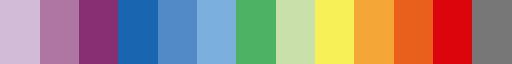

In [2118]:
# colors = sns.color_palette('tab20', len(to_plot_min)).as_hex()
# random.seed(10); random.shuffle(colors)
all_colors = np.array(['#777777', '#E8ECFB', '#D9CCE3', '#D1BBD7', '#CAACCB', '#BA8DB4', '#AE76A3', '#AA6F9E', 
                       '#994F88', '#882E72', '#1965B0', '#437DBF', '#5289C7', '#6195CF', '#7BAFDE', '#4EB265', 
                       '#90C987', '#CAE0AB', '#F7F056', '#F7CB45', '#F6C141', '#F4A736', '#F1932D', '#EE8026', 
                       '#E8601C', '#E65518', '#DC050C', '#A5170E', '#72190E', '#42150A'])
colors = all_colors[[3,6,9,10,12,14,15,17,18,21,24,26,0]]
cmap = ListedColormap(colors, name='Z'); cmap

In [2121]:
criteria_map = {name: color for name, color in zip(results_filter_min['webkb'].keys(), colors)}

### Figure sizing

In [2046]:
mm = 1/2.54/10

In [2145]:
fig_width = 174*mm

In [2049]:
fig_max_height = 195*mm

## Metrics

In [2189]:
order = list(name_map.values())

In [2194]:
x_map = {results_plots[i][0].dataset_name: results_plots[i][1][0].x for i in range(len(results_plots))}
accuracy_map = {results_plots[i][0].dataset_name: np.mean([results_plots[i][1][j].accuracy_score for j in range(len(results_plots[i][1]))], axis=0) for i in range(len(results_plots))}
accuracy_upper_map = {results_plots[i][0].dataset_name: np.percentile([results_plots[i][1][j].accuracy_score for j in range(len(results_plots[i][1]))], 97.5, axis=0) for i in range(len(results_plots))}
accuracy_lower_map = {results_plots[i][0].dataset_name: np.percentile([results_plots[i][1][j].accuracy_score for j in range(len(results_plots[i][1]))], 2.5, axis=0) for i in range(len(results_plots))}
thresholds = {'SSNCut': None,
 'Entropy-MCS': 0.01,
 'OracleAcc-MCS': 0.9,
 'MES': 0.01,
 'Stabilizing predictions': 0.99,
 'Performance convergence': None,
 'Uncertainty convergence': None,
 'Max confidence': 0.001,
 'EVM': None,
 'VM': None,
 'Contradictory information': None,
 'Overall uncertainty': 0.01, 
 'Classification change': None}
lims = {
    'OracleAcc-MCS': (None, 1.),
    'Entropy-MCS': (0., None),
    'Contradictory information': (0., None),
    'Stabilizing predictions': (None, 1.),
    'Performance convergence': (None, 1.),
    'Uncertainty convergence': (0., None),
    'Max confidence': (0., None),
    'Classification change': (None, 1.),
    'Overall uncertainty': (0, None),
    'VM': (0, None), 'EVM': (0, None),
}

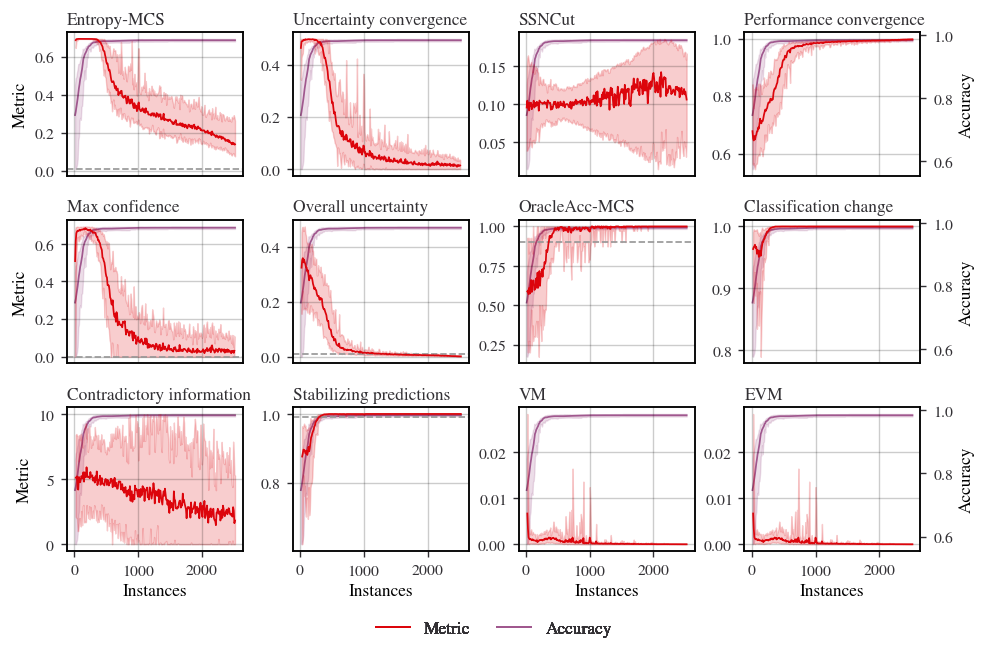

In [2264]:
def metrics_plot(results, dataset='spamassassin', figsize=(8.,5), dpi=125, cols=4, set_lims=True, plot_accuracy=True):
    conds = results[dataset]
    x = x_map[dataset]
    accuracy = accuracy_map[dataset]
    accuracy_upper = accuracy_upper_map[dataset]
    accuracy_lower = accuracy_lower_map[dataset]
    dataset = dataset.rstrip("-58509")
    
    fig, axes = plt.subplots(math.ceil(len(conds)/cols), cols, figsize=figsize, dpi=dpi)
    
    new = {}
    for name in order:
        new[name] = conds[name]
    conds = new
    
    for i, (ax, (cname, runs)) in enumerate(zip(axes.flatten(), conds.items())):
        ax.set_title(cname)
        ax.grid(color='black', alpha=0.2)
        
        mets = []
        for run in runs:
            try:
                run.metric
            except AttributeError:
                print(type(runs))
                print(cname, run)
            if isinstance(run.metric, tuple):
                mets.append([*[np.nan]*(len(x)-len(run.metric[0])), *run.metric[0]])
            else:
                mets.append([*[np.nan]*(len(x)-len(run.metric)), *run.metric])
        mean = np.mean(mets, axis=0)
        upper = np.percentile(mets, 97.5, axis=0)
        lower = np.percentile(mets, 2.5, axis=0)
        
        # accuracy
        if plot_accuracy:
            ax2 = ax.twinx()
            l = ax2.plot(x, accuracy, lw=1., color=color_alpha([cmap(2)],0.8)[0], label="Accuracy" if i == 0 else None, zorder=4)
            ax2.fill_between(x, accuracy_lower, accuracy_upper, color=l[0].get_color(), alpha=0.2, zorder=2)
                
        # Metric
        l = ax.plot(x, mean, lw=1., color=cmap(11), label="Metric" if i == 0 else None, zorder=3)
        ax.fill_between(x, lower, upper, color=l[0].get_color(), alpha=0.2, zorder=1)
        
        # Stop points
        
        # Thresholds
        if thresholds[cname] is not None:
            ax.axhline(thresholds[cname], color=color_alpha(['grey'],0.8)[0], lw=1., ls='--')
        # Limits
        if cname in lims and set_lims:
            ax.set_ylim(lims[cname])
        
        if i % cols == 0:
            ax.set_ylabel("Metric")
        if i % cols == cols-1:
            ax2.set_ylabel("Accuracy")
        else:
            ax2.set_yticklabels(())
            for tic in ax2.yaxis.get_major_ticks():
                tic.tick1line.set_visible(False)
                tic.tick2line.set_visible(False)
        if i > len(conds)-cols-1:
            ax.set_xlabel("Instances")
        else:
            ax.set_xticklabels(())
            for tic in ax.xaxis.get_major_ticks():
                tic.tick1line.set_visible(False)
                tic.tick2line.set_visible(False)
            
        for spine in ax2.spines.values():
            spine.set_edgecolor('#777')
            
        fig.legend(bbox_to_anchor=(0.5, -0.05), loc='lower center', ncol=2, frameon=False)
        
        ax.set_zorder(2)
        ax2.set_zorder(1)
        ax.patch.set_visible(False)
    
    fig.tight_layout(w_pad=0.5, h_pad=1.0)
    
with plt.style.context('plt_style.txt'):
    plt.rcParams['axes.titlesize'] = 10
    plt.rcParams['axes.linewidth'] = 1
    plt.rcParams['axes.labelsize'] = 10
    plt.rcParams['axes.spines.right'] = True
    plt.rcParams['axes.spines.top'] = True
    plt.rcParams['xtick.labelsize'] = 9
    plt.rcParams['ytick.labelsize'] = 9
    #plt.rcParams['lines.markeredgecolor']: black
    #plt.rcParams['patch.facecolor'] = 'bc80bd'
    #patch.force_edgecolor  : True
    #patch.linewidth: 0.8
    metrics_plot(results_filter_min, set_lims=False)
plt.savefig('pdf/metric_comparison.pdf', bbox_inches='tight')

* To show MES on this plot merge VM/EVM into one plot as they use the same metric
* Use last space for MES - BAM WHAMO DONEZO

## Full Range Pareto Plots

In [2138]:
fig_width/mm

174.0

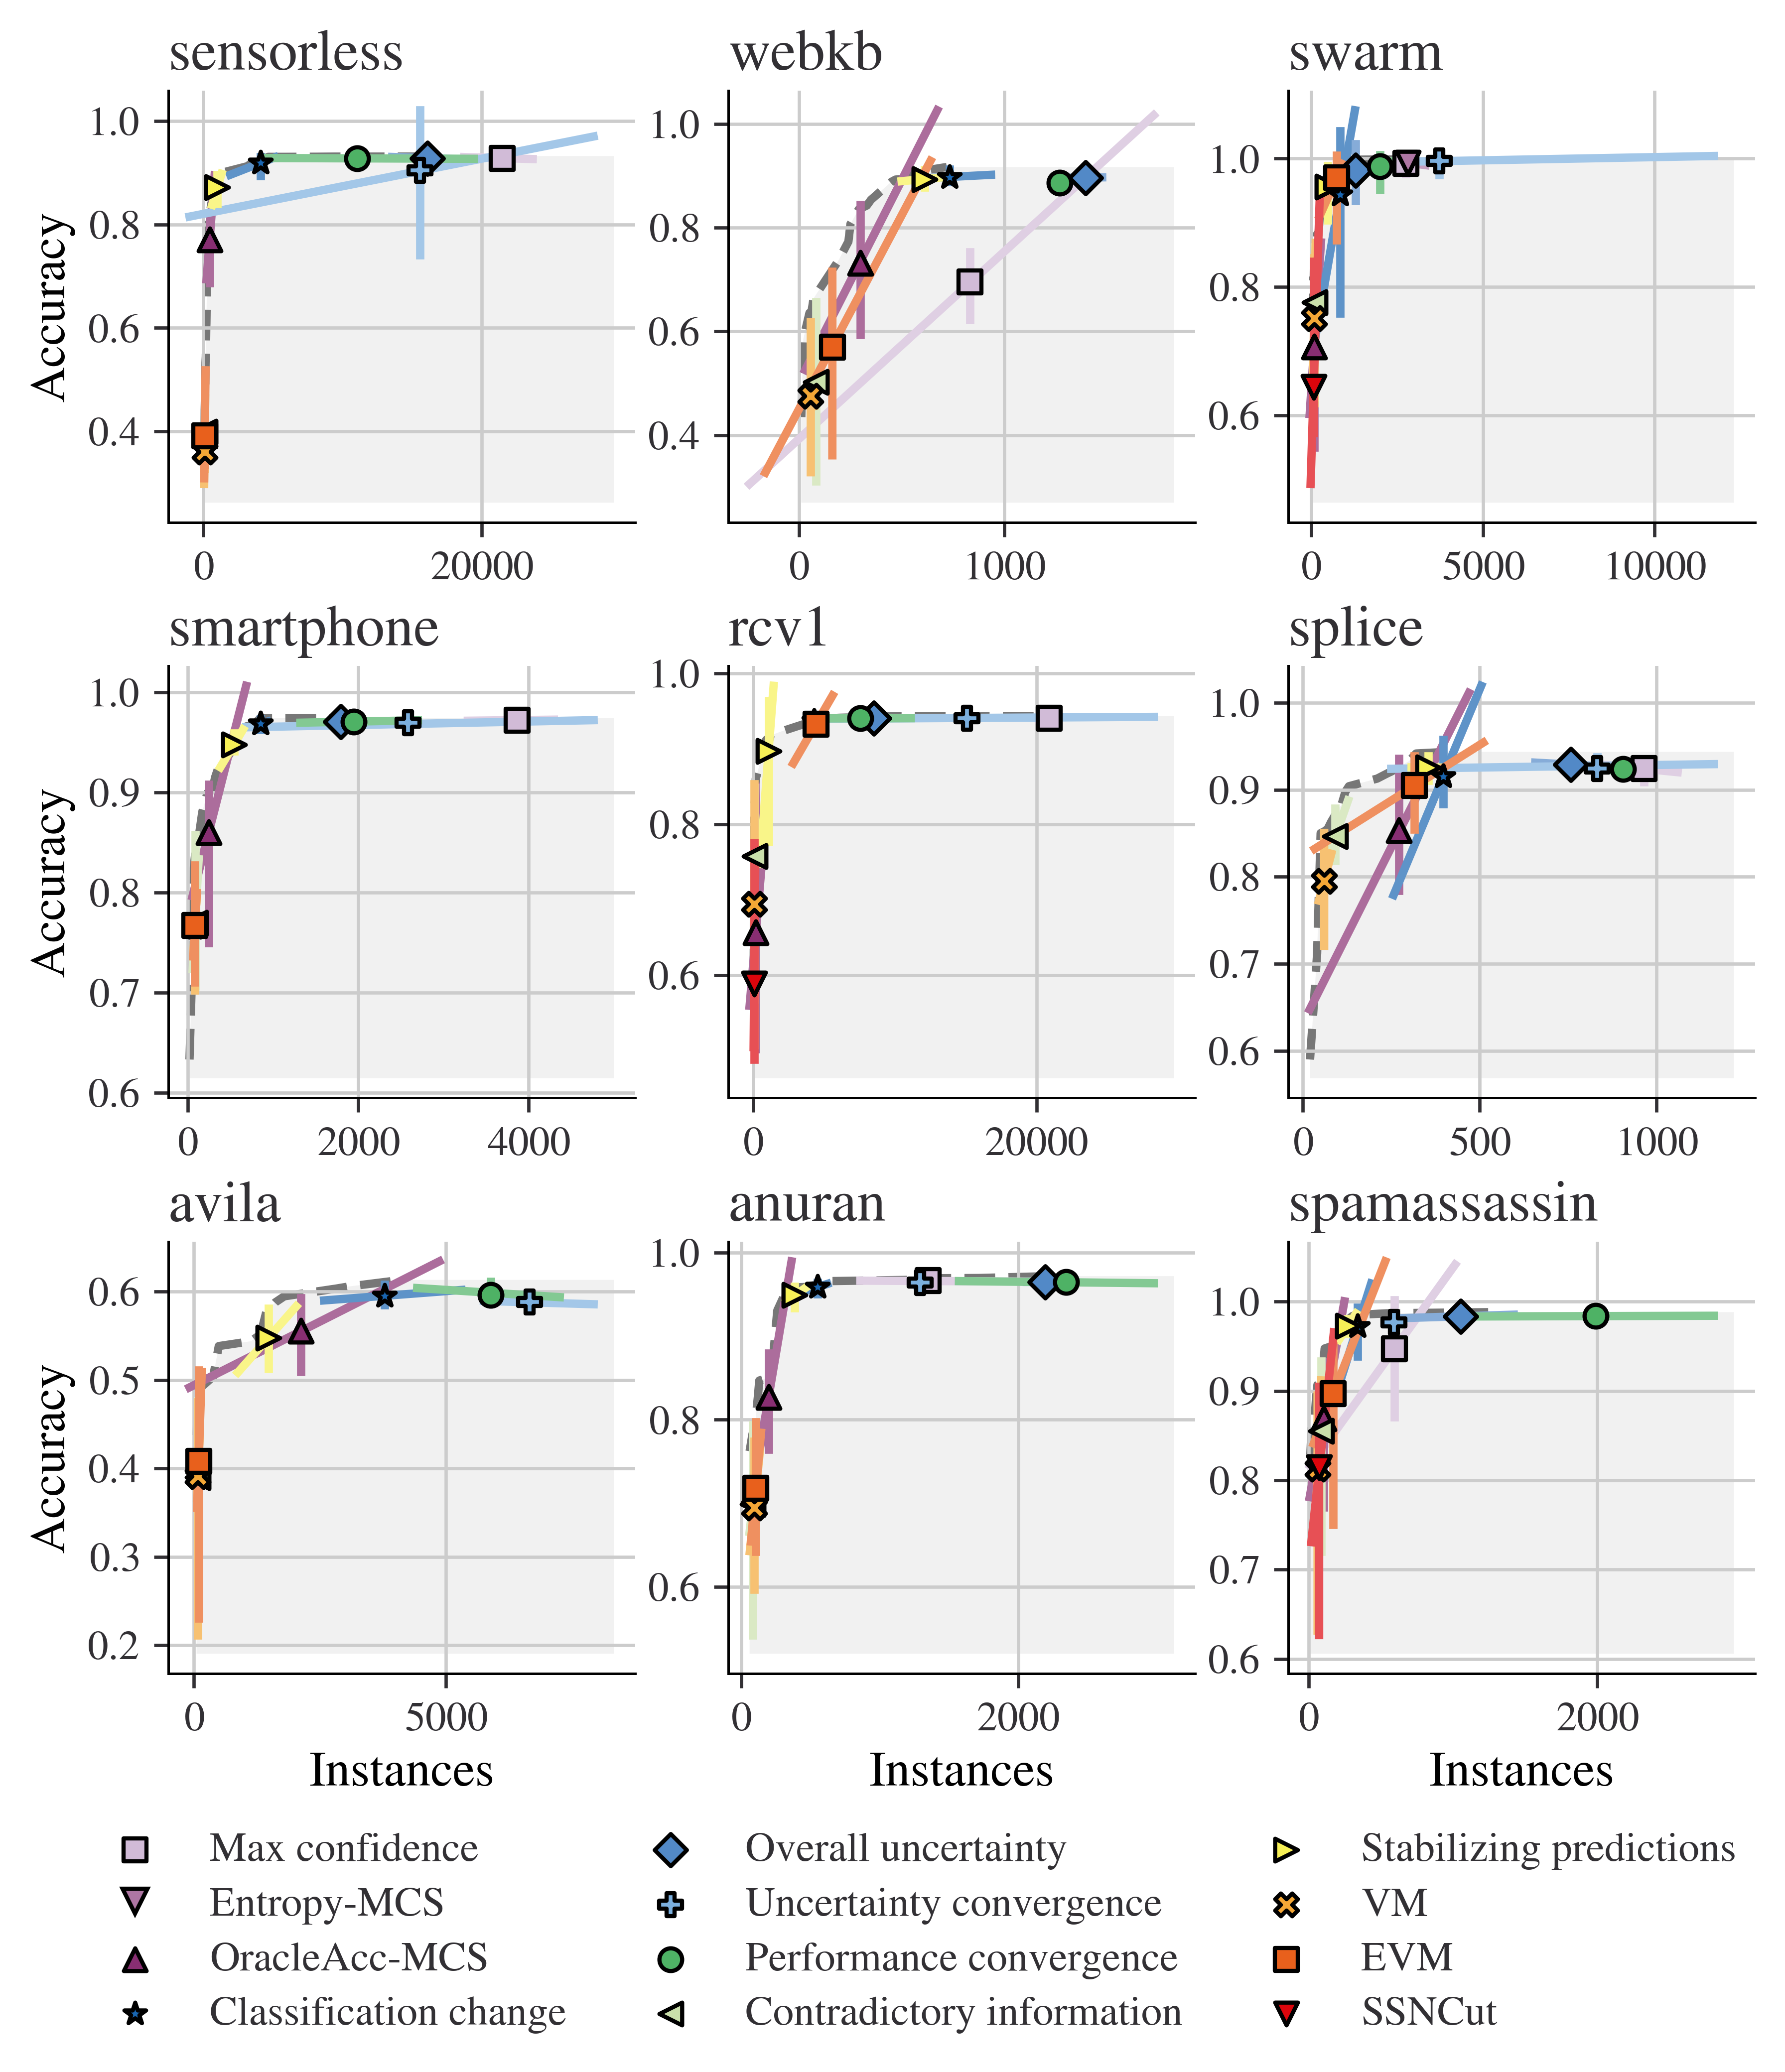

In [2244]:
reload(libplot); from libplot import plot_paraeto_hull
with plt.style.context('plt_style.txt'):
    plot_paraeto_hull(results_filter_min, rows=3, cols=3, figsize=(fig_width,180*mm), dpi=600, hull=False, error='pca', colors=criteria_map, legend_loc='upper center', legend_cols=3, legend_bbox=(-0.8, -0.3))
plt.savefig('pdf/pareto_svm.pdf', bbox_inches='tight')

Errors drawn asymmetrically using 2.5% and 97.5% percentiles.

### Optimal Regions (Ranking Formula)

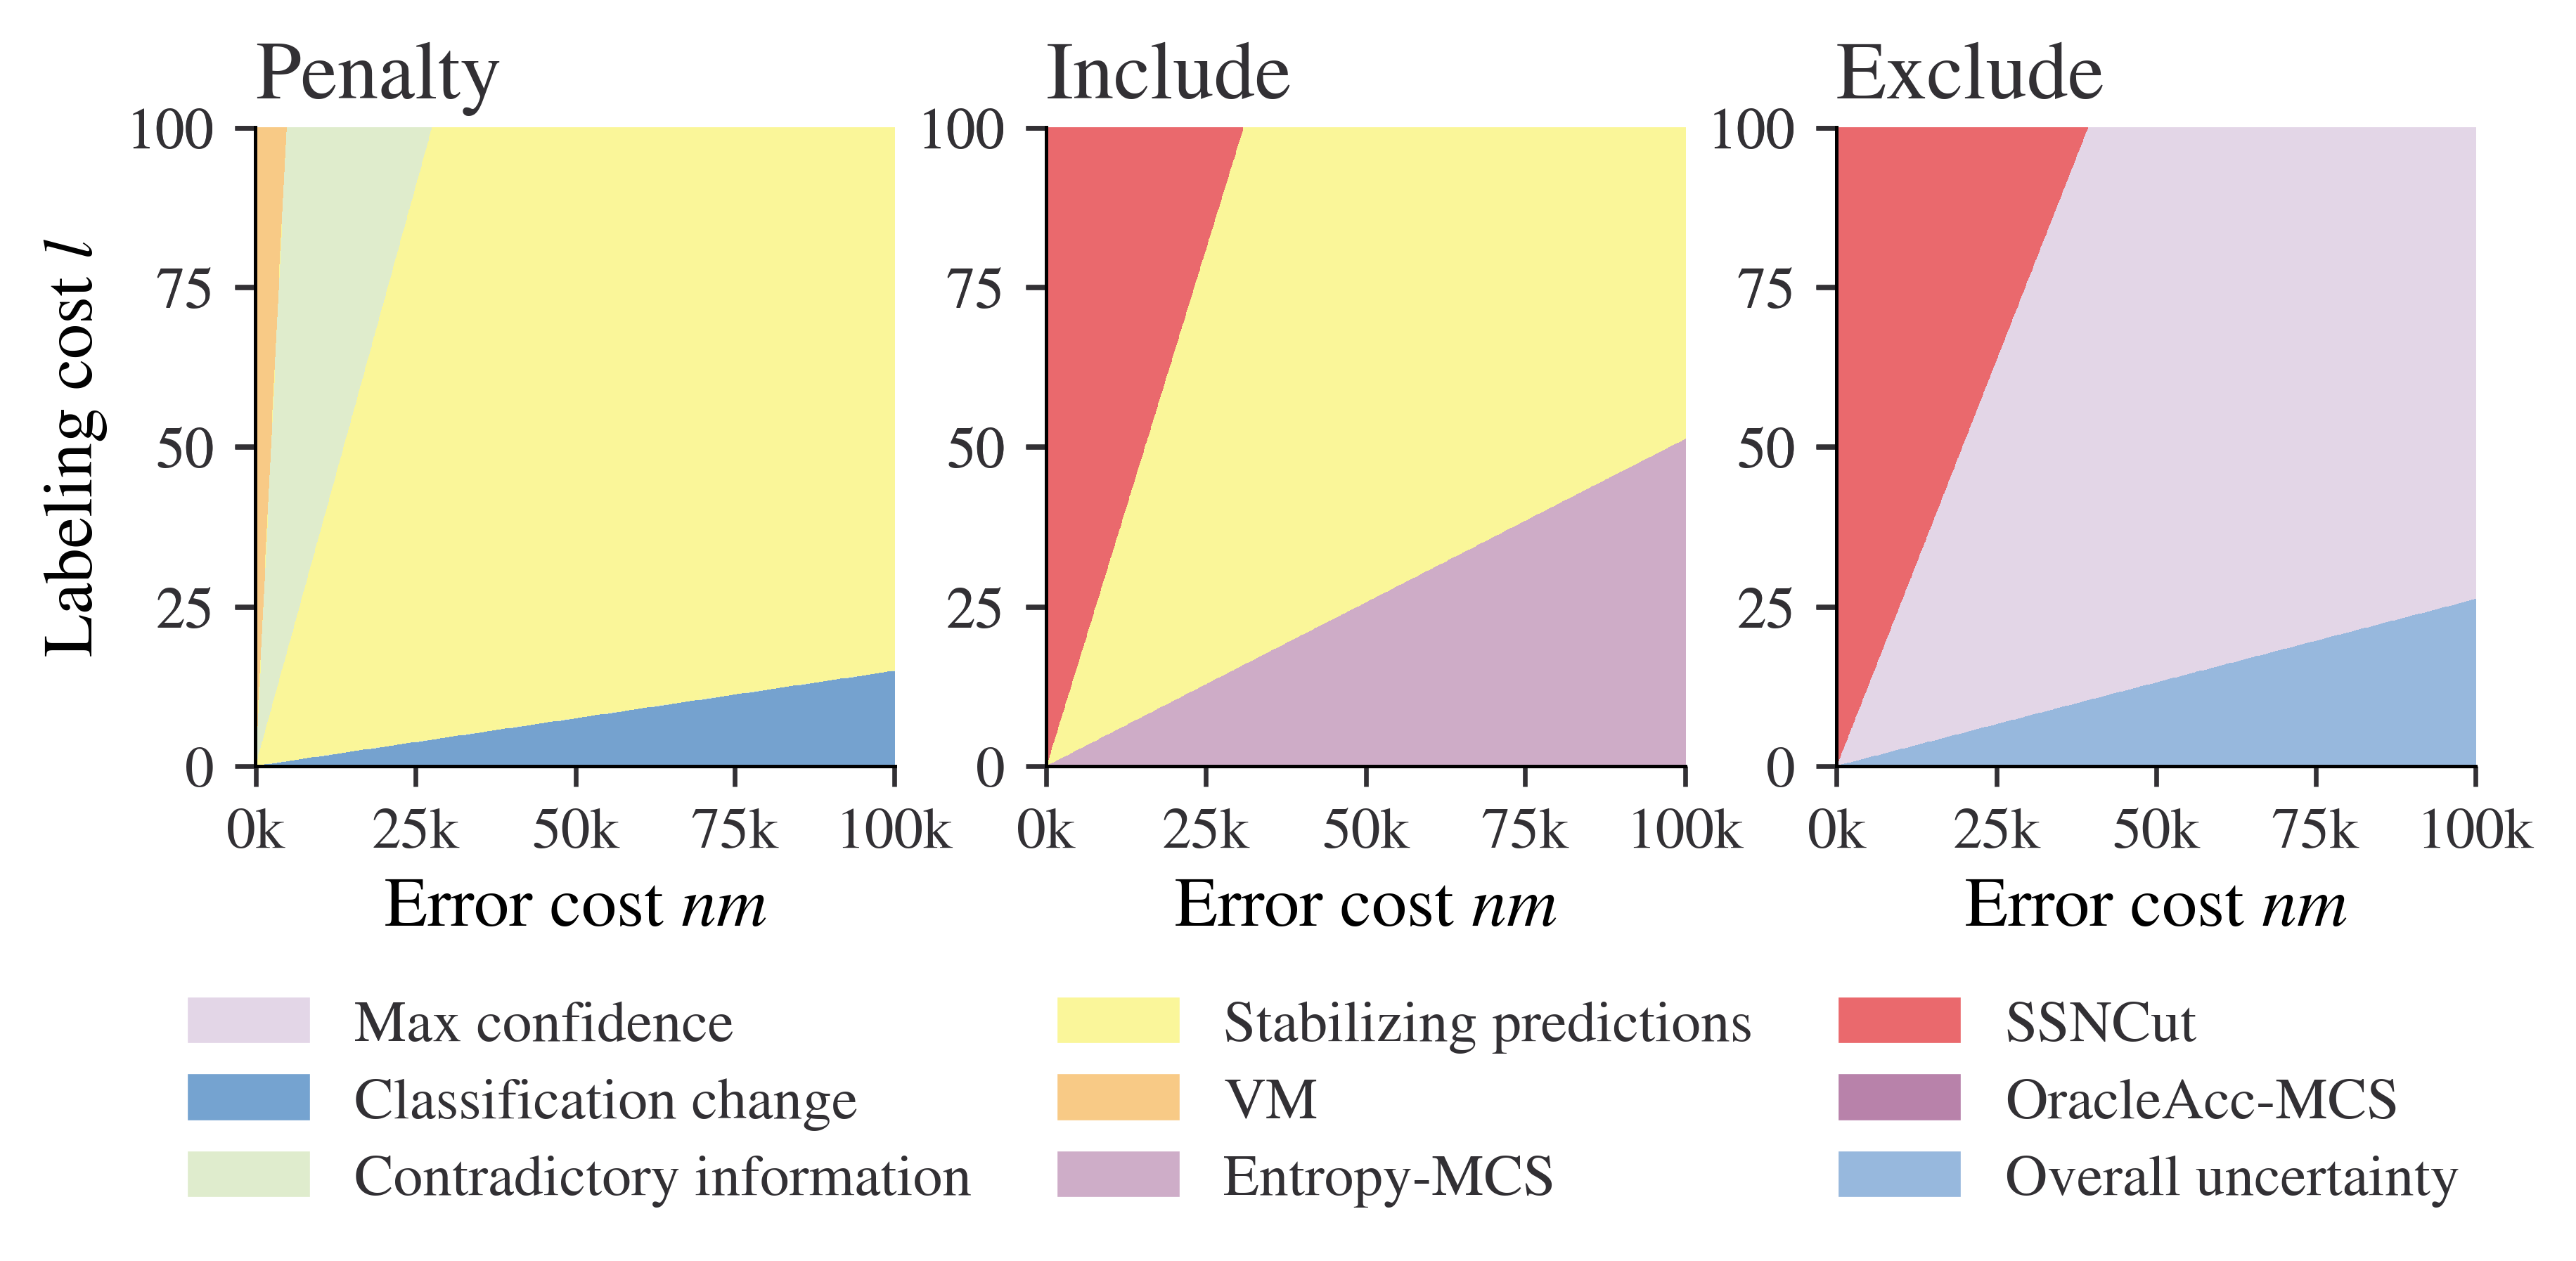

In [2223]:
reload(libregionplot); from libregionplot import regions, costs
with plt.style.context('plt_style.txt'):
    fig, axes = plt.subplots(1, 3, figsize=(fig_width, 50*mm), dpi=600)
    patches = []
    for i, (ax, mode) in enumerate(zip(axes, ['penalty', 'include', 'exclude'])):
        regions(results_filter_min, colors=criteria_map, failed_to_stop=mode, title=mode.title(), ax=ax, patches=patches, left=i==0, alpha=0.6)
    plt.legend(handles=patches, bbox_to_anchor=(-0.8, -0.3), loc="upper center", ncol=3, frameon=False)
plt.savefig('pdf/cost_svm.pdf', bbox_inches='tight')

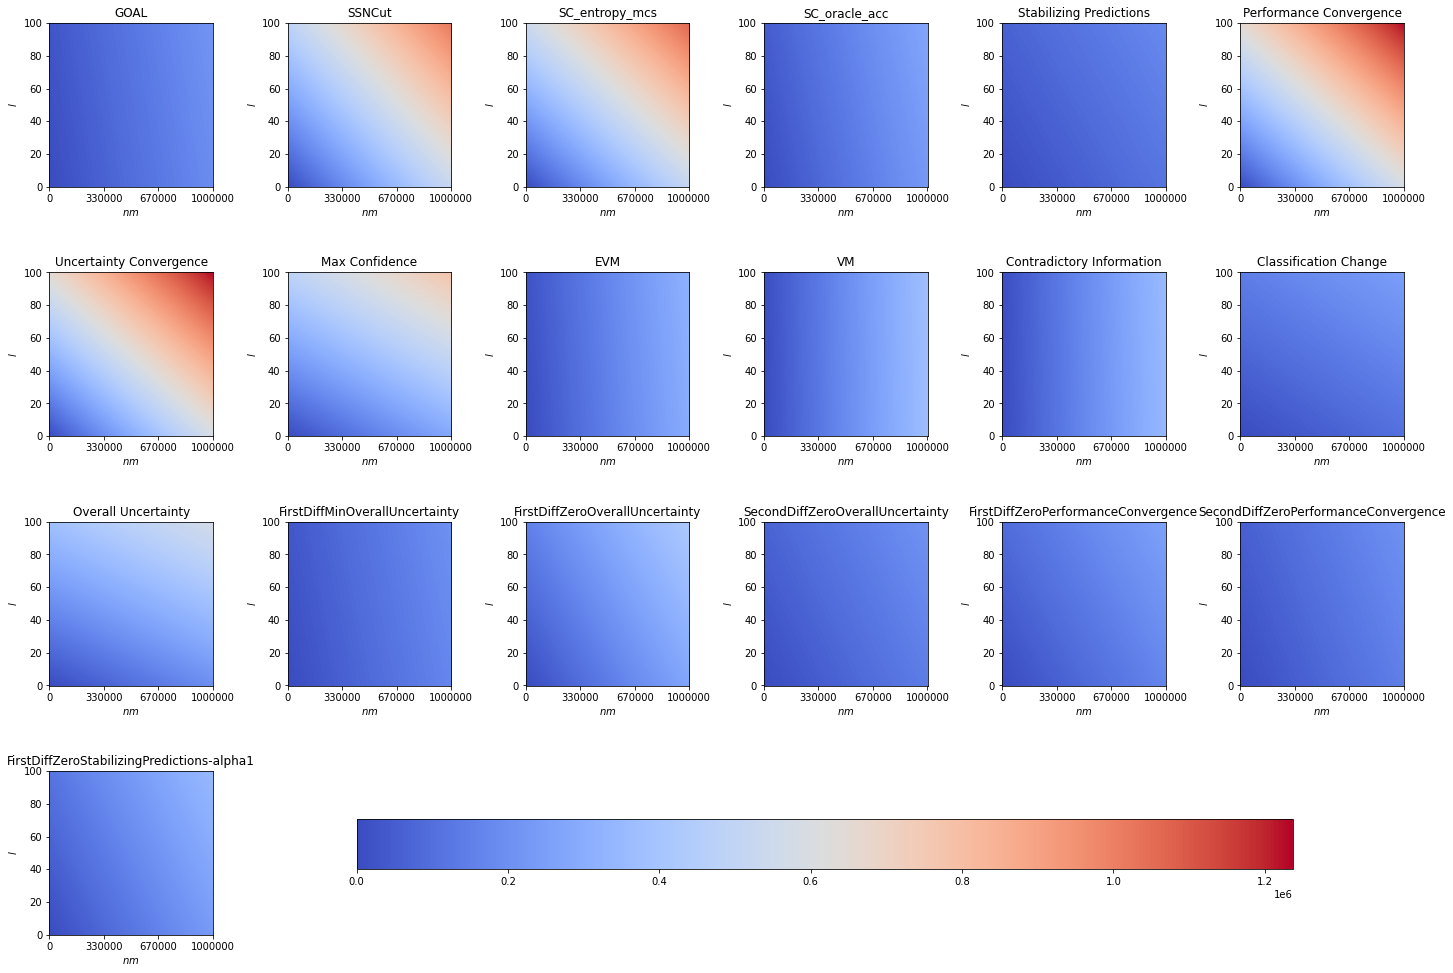

In [846]:
costs(results_filter)

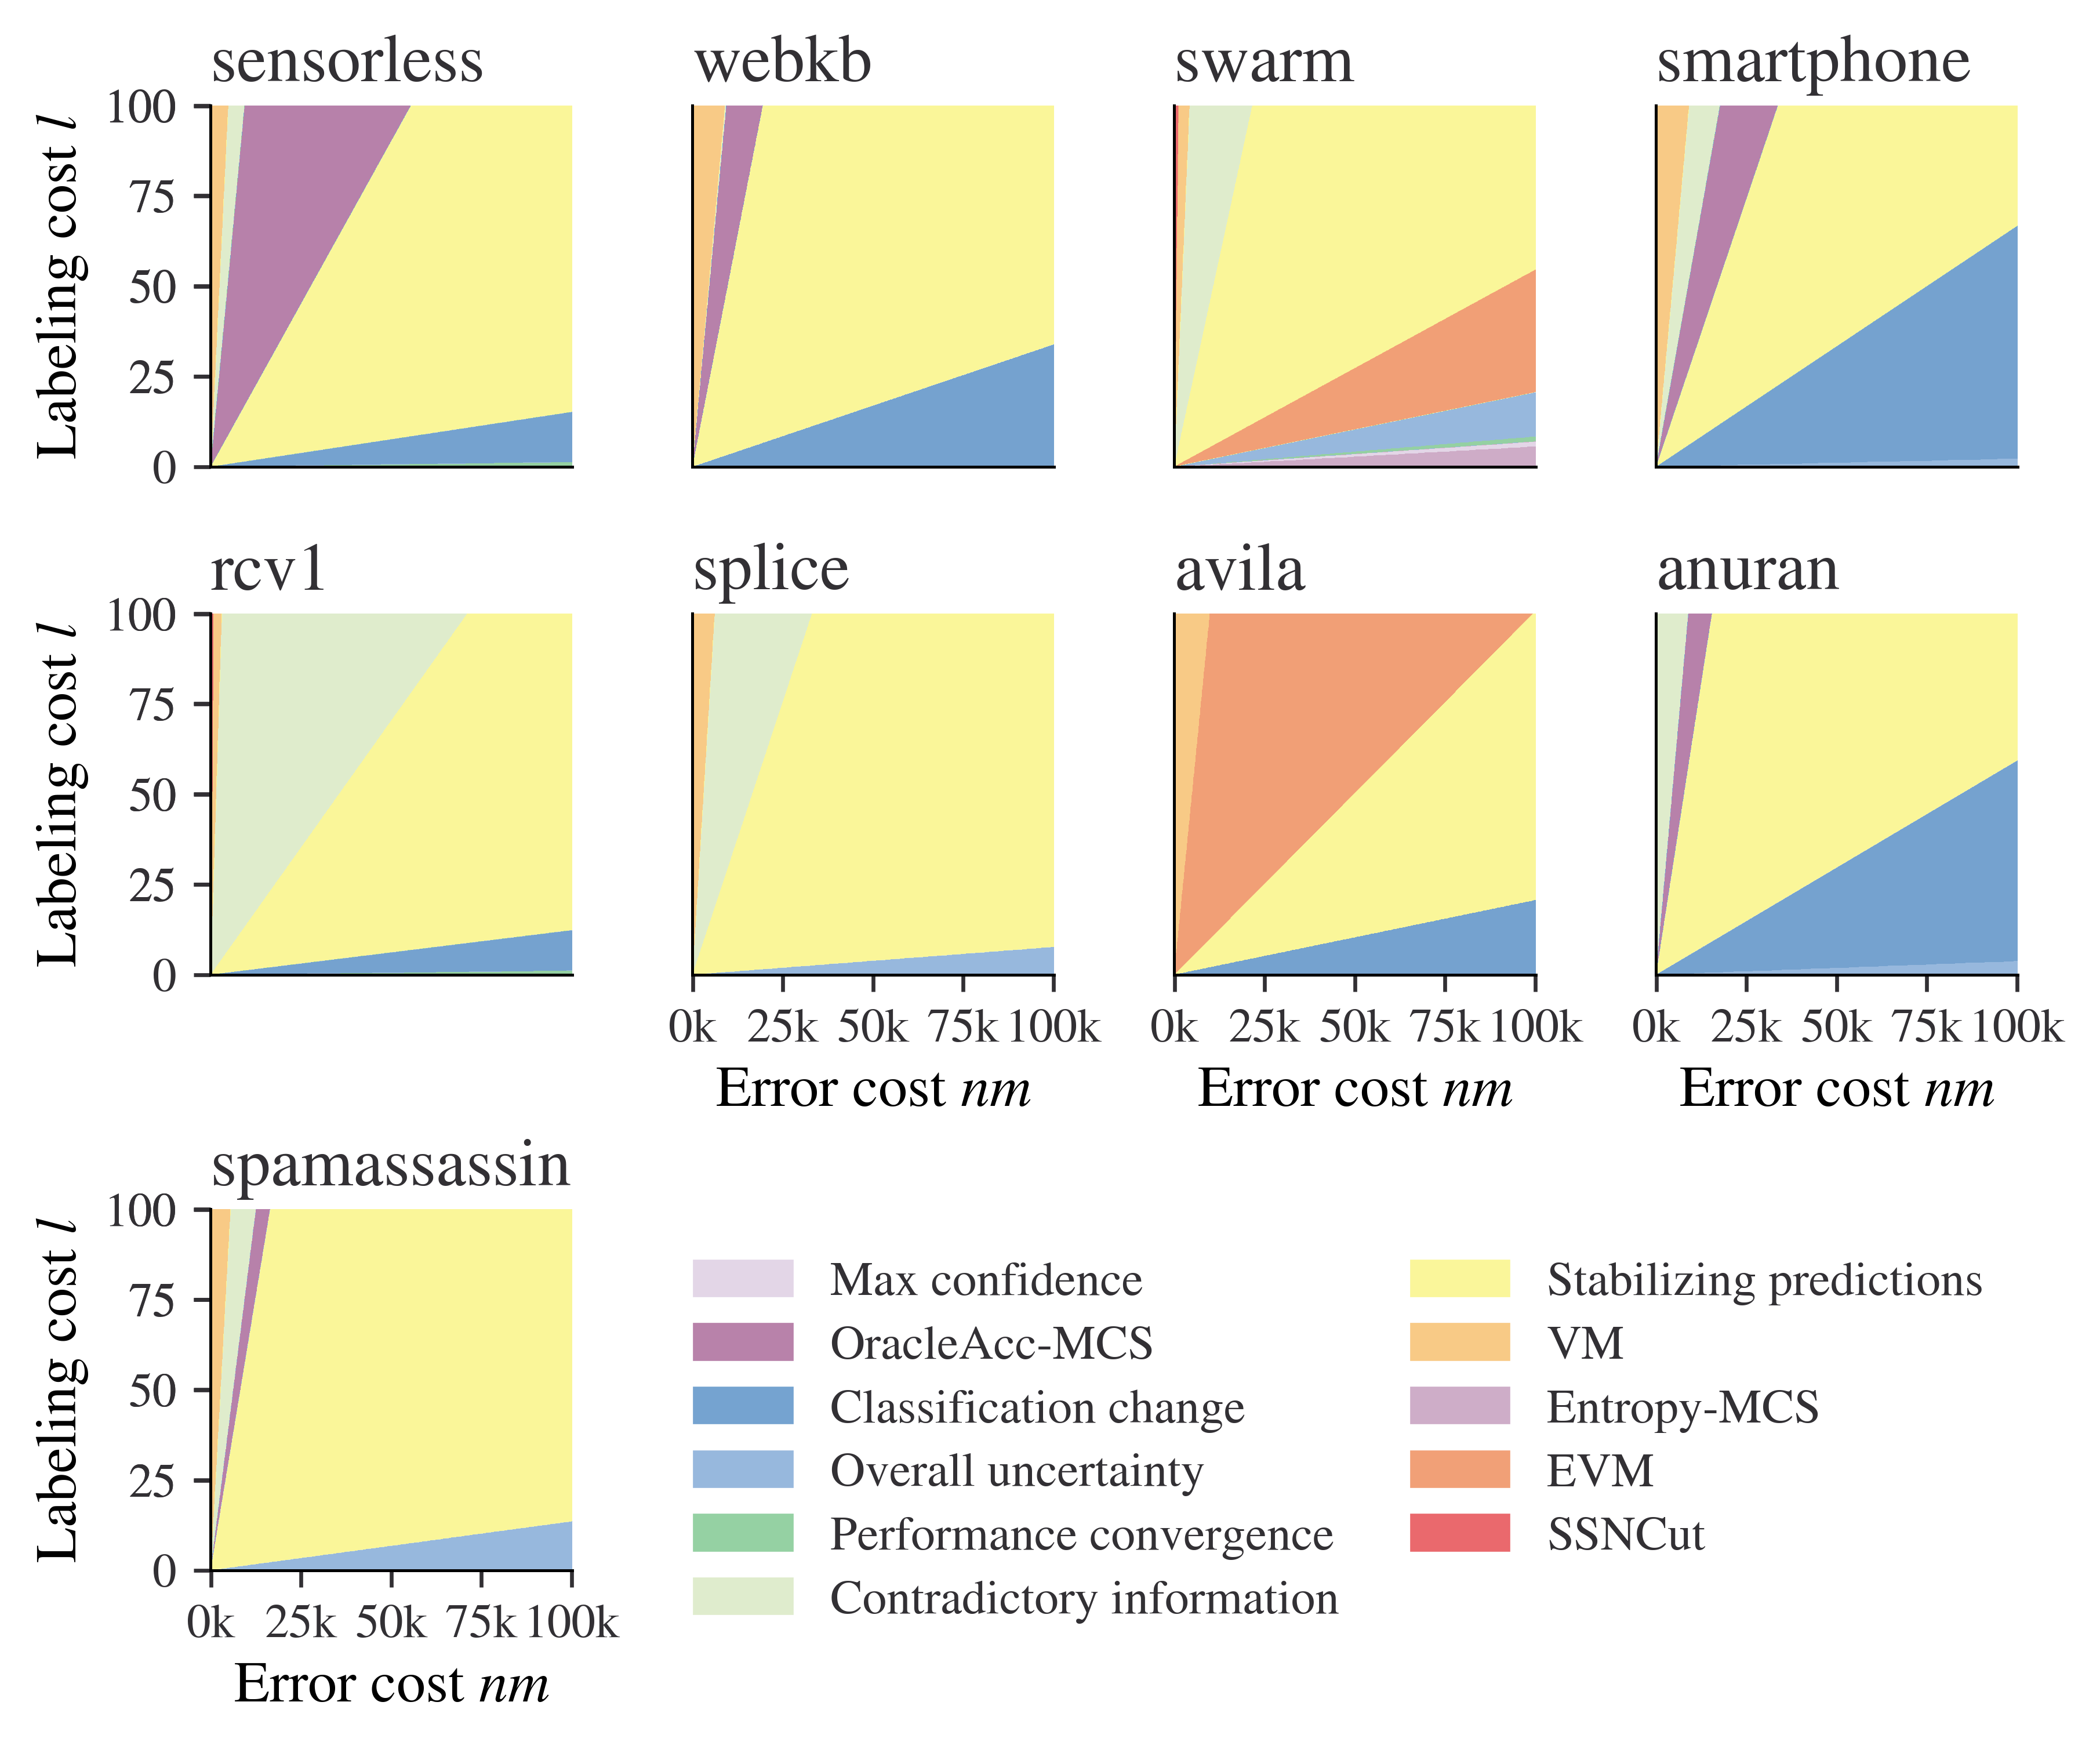

In [2224]:
import libregionplot; reload(libregionplot); from libregionplot import regions, costs
import math
with plt.style.context('plt_style.txt'):
    fig, axes = plt.subplots(math.ceil(len(results_filter_min)/4), 4, figsize=(fig_width,6.3), dpi=600)
    patches = []
    for i, ((dataset, r), ax) in enumerate(zip(results_filter_min.items(), axes.flatten())):
        regions(
            {dataset: r}, 
            colors=criteria_map, 
            failed_to_stop="penalty", 
            title=dataset.rstrip("-58509"), 
            ax=ax, 
            patches=patches, 
            left=i%4==0, 
            bottom=i>len(results_filter_min)-5,
            alpha=0.6)
    # remove duplicate ticks (to avoid distractions)
    for i in [1,2,3,5,6,7]: # remove yticks
        axes.flatten()[i].tick_params(left=False, labelleft=False)
    for i in [0,1,2,3,4]: # remove xticks
        axes.flatten()[i].tick_params(bottom=False, labelbottom=False)
        
    for ax in axes.flatten()[len(results_filter_min):]:
        fig.delaxes(ax)
    for ax in axes.flatten():
        box = ax.get_position()
        ax.set_position([box.x0, box.y0 + box.height * 0.1,
                         box.width, box.height * 0.9])
    for ax in axes.flatten()[4:]:
        box = ax.get_position()
        ax.set_position([box.x0, box.y0+0.04, box.width, box.height])
    plt.legend(handles=patches, bbox_to_anchor=(5., 0.95), ncol=2, frameon=False)
    
    #plt.suptitle("Linear SVM (Penalty)")
plt.savefig('pdf/cost_datasets_svm.pdf', bbox_inches='tight')

### Attempt to fix

In [1992]:
from autorank import autorank, plot_stats
import libregionplot; reload(libregionplot); from libregionplot import *

In [2154]:
def new_autorank(n, m, l, compare_ranks=False, title='Autorank', height=3.8):
    C_rel_ex = np.vectorize(C_rel_nonvec, signature="(a,b),(a,b),(),()->(a,b)")
    conds, instances, accuracy = compute_criteria_arrays_autorank(results_filter_min)
    costs = C_rel_ex(accuracy, instances, n*m, l)
    df = pd.DataFrame(costs.T, columns=conds)
    rankresult = autorank(df, order="ascending")
    fig, ax = plt.subplots(1, 1, figsize=(fig_width, height))
    plot_stats(rankresult, ax=ax)
    if title is not None:
        ax.set_title(title)
    if compare_ranks:
        print("median:", df.median().sort_values().index)
        print("mean:", df.mean().sort_values().index)
        print("AUTORANK median:", rankresult.rankdf.sort_values('median').index)
        print("AUTORANK medianrank:", rankresult.rankdf.sort_values('meanrank').index)

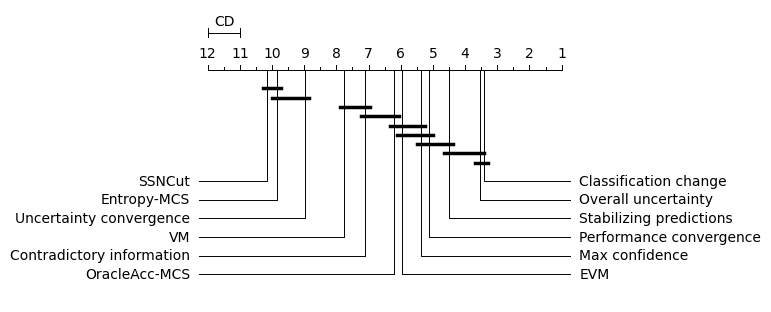

In [2225]:
# Mammogram example
new_autorank(336000, 10742, 13.6, title=None)
plt.savefig('pdf/ex_mammogram_svm.pdf', bbox_inches='tight')

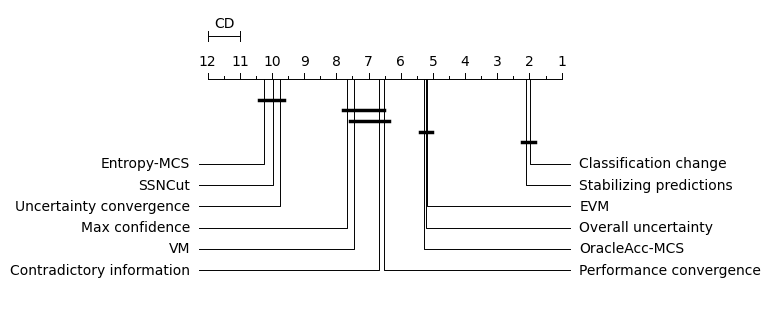

In [2226]:
# Marketing example
new_autorank(2000, 20, 1, title=None)
plt.savefig('pdf/ex_marketing_svm.pdf', bbox_inches='tight')

## Failed To Stop

In [2128]:
table = []
for dataset, methods in results_filter_min.items():
    table.append([])
    for method, results in methods.items():
        table[-1].append(np.count_nonzero([result[0] for result in results]))

In [2129]:
failed_to_stop = pd.DataFrame(table, [s.rstrip("-58509") for s in results_filter_min.keys()], list(results_filter_min['webkb'].keys()))

In [1696]:
failed_to_stop[failed_to_stop.sum().sort_values().index[::-1]]

,Classification Change,Contradictory Information,VM,Stabilizing Predictions,EVM,SC_oracle_acc,Overall Uncertainty,Performance Convergence,Max Confidence,SSNCut,Uncertainty Convergence,SC_entropy_mcs
sensorless,30,30,30,30,30,30,30,30,30,0,19,0
webkb,30,30,30,30,30,30,13,1,25,0,0,0
swarm,30,30,30,30,30,30,30,30,30,30,16,30
smartphone,30,30,30,30,30,30,30,30,3,0,4,0
rcv1,30,30,30,30,30,30,30,30,30,30,8,0
splice,30,30,30,30,30,30,30,8,26,0,4,0
avila,30,30,30,30,0,0,0,30,4,30,5,0
anuran,30,30,30,30,30,30,30,25,5,0,3,0
spamassassin,30,30,30,30,30,30,30,18,30,30,1,0


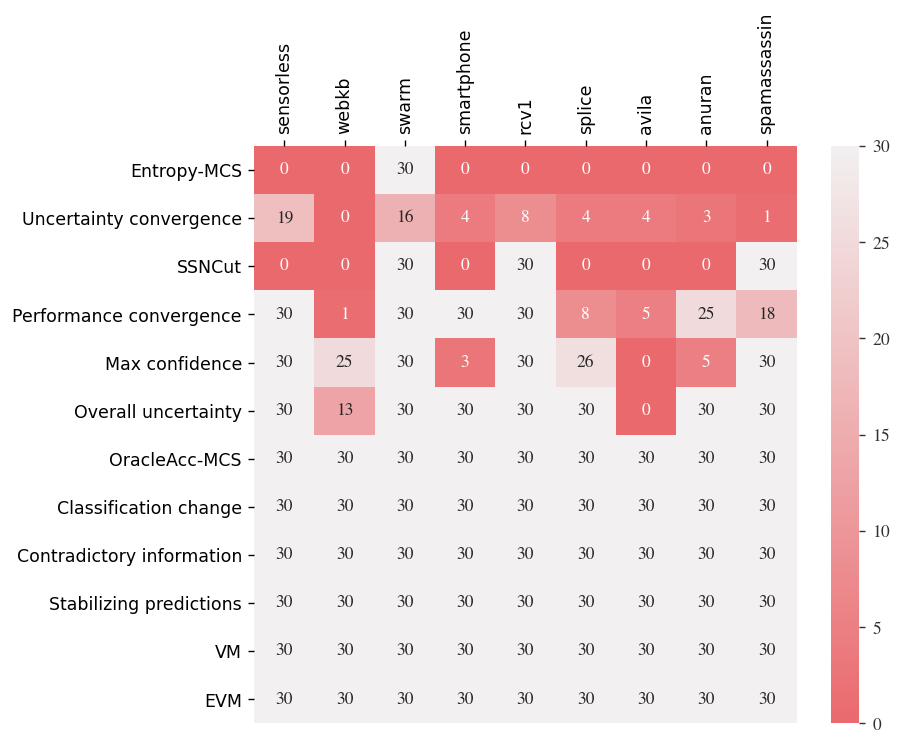

In [2167]:
def failed_to_stop_plot(ax, failed_to_stop, color=None, alpha=0.6):
    if ax is None:
        fig, ax = plt.subplots(1,1, figsize=(7,6), dpi=125)
    with plt.style.context('plt_style.txt'):
        
        sns.heatmap(failed_to_stop.T, annot=True, ax=ax, cmap=sns.light_palette(color_alpha([color], alpha)[0], as_cmap=True, reverse=True));
        ax.xaxis.tick_top() # x axis on top
        ax.xaxis.set_label_position('top')
        ax.set_xticklabels(ax.get_xticklabels(), rotation=90);
failed_to_stop_plot(None, failed_to_stop[failed_to_stop.sum().sort_values().index], color=cmap(11))

## Pearson Correlation Coefficients

**Iterating over results is not the same dataset order as everything else now, take care!**

Only used in metrics comparison plot (to check) and this one.

In [1773]:
from collections import defaultdict

In [2133]:
accs = defaultdict(list)
mets = defaultdict(list)
for dataset, methods in results_filter_min.items():
    for method, runs in methods.items():
        
        for conf, rplots in results_plots:
            if conf.dataset_name == dataset:
                dataset_results = rplots
                break
            
        accuracies = []
        metrics = []
        for i, run in enumerate(runs):
            if run.metric is None:
                continue
            accuracies.append(dataset_results[i].accuracy_score)
            if isinstance(run.metric, tuple):
                metrics.append(run.metric[0])
            else:
                metrics.append(run.metric)
            if len(accuracies[-1]) != len(metrics[-1]):
                # TODO: Fix off by one in SC_oracle_acc
                if method == "OracleAcc-MCS":
                    metrics[-1] = [np.nan, *metrics[-1]]
                else:
                    print(dataset, method)
                    print(f"{len(accuracies[-1])} != {len(metrics[-1])}")
                    raise Exception()
        
        a = np.array(accuracies).flatten()
        m = np.array(metrics).flatten()
        
        # remove nan metric observations
        mask =~ np.isnan(m)
        m = m[mask]
        a = a[mask]
        
        accs[method].append(a)
        mets[method].append(m)

In [2134]:
correlations = {
    method: np.mean([scipy.stats.pearsonr(acc, met)[0] for acc, met in zip(accs[method], mets[method]) if len(acc) >= 2])
    for method in results_filter_min['spamassassin'].keys()
}
correlations_err = {
    method: scipy.stats.sem([scipy.stats.pearsonr(acc, met)[0] for acc, met in zip(accs[method], mets[method]) if len(acc) >= 2])
    for method in results_filter_min['spamassassin'].keys()
}

In [2168]:
def plot_correlations(ax, k, v, yerr, abs_v=True, title="Correlations", labels=True, width=0.8, order=True, color=None, alpha=0.6):
    k, v, yerr = list(k), list(v), list(yerr)
    if abs_v:
        v = np.abs(v)
    if order:
        order = np.argsort(v)
        k = np.array(k)[order]
        v = np.array(v)[order]
    else:
        k = np.array(k)
        v = np.array(v)
    ax.barh(k, v, xerr=yerr, height=width, color=color_alpha([color], alpha)[0])
    ax.set_ylabel("Absolute Pearsons r value")
    if not labels:
        ax.set_yticks(())
    #ax.set_title(title)
    #plt.xticks(rotation=90)

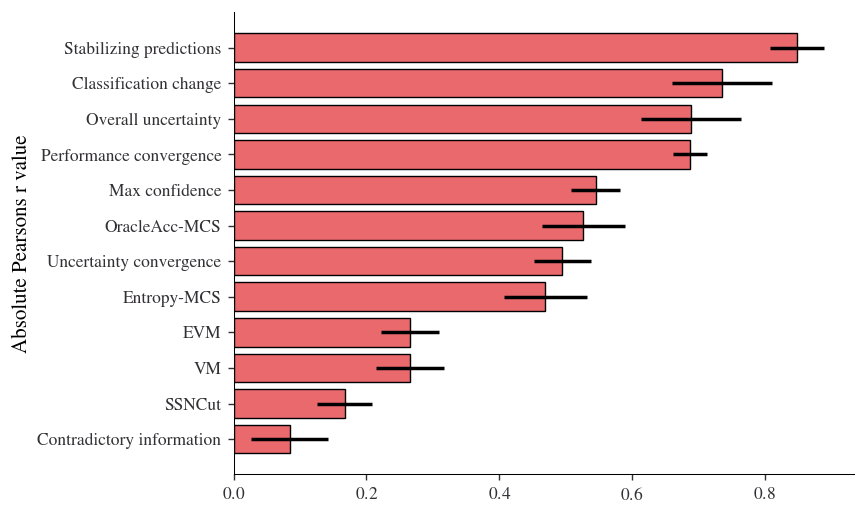

In [2169]:
with plt.style.context('plt_style.txt'):
    fig, ax = plt.subplots(1, 1, dpi=125)
    plot_correlations(ax, correlations.keys(), correlations.values(), correlations_err.values(), color=cmap(11))

* TODO: Can we convert the two tailed p value to error?

## Combined Plot

In [2135]:
correlations_frame = pd.DataFrame({
        'r': correlations.values(),
        'r_err': correlations_err.values()
    },
    index=correlations.keys()
)

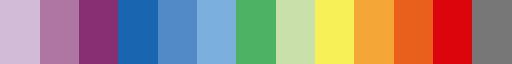

In [1950]:
cmap

(12.0, 0.0)
(-0.9900000000000001, 11.99)


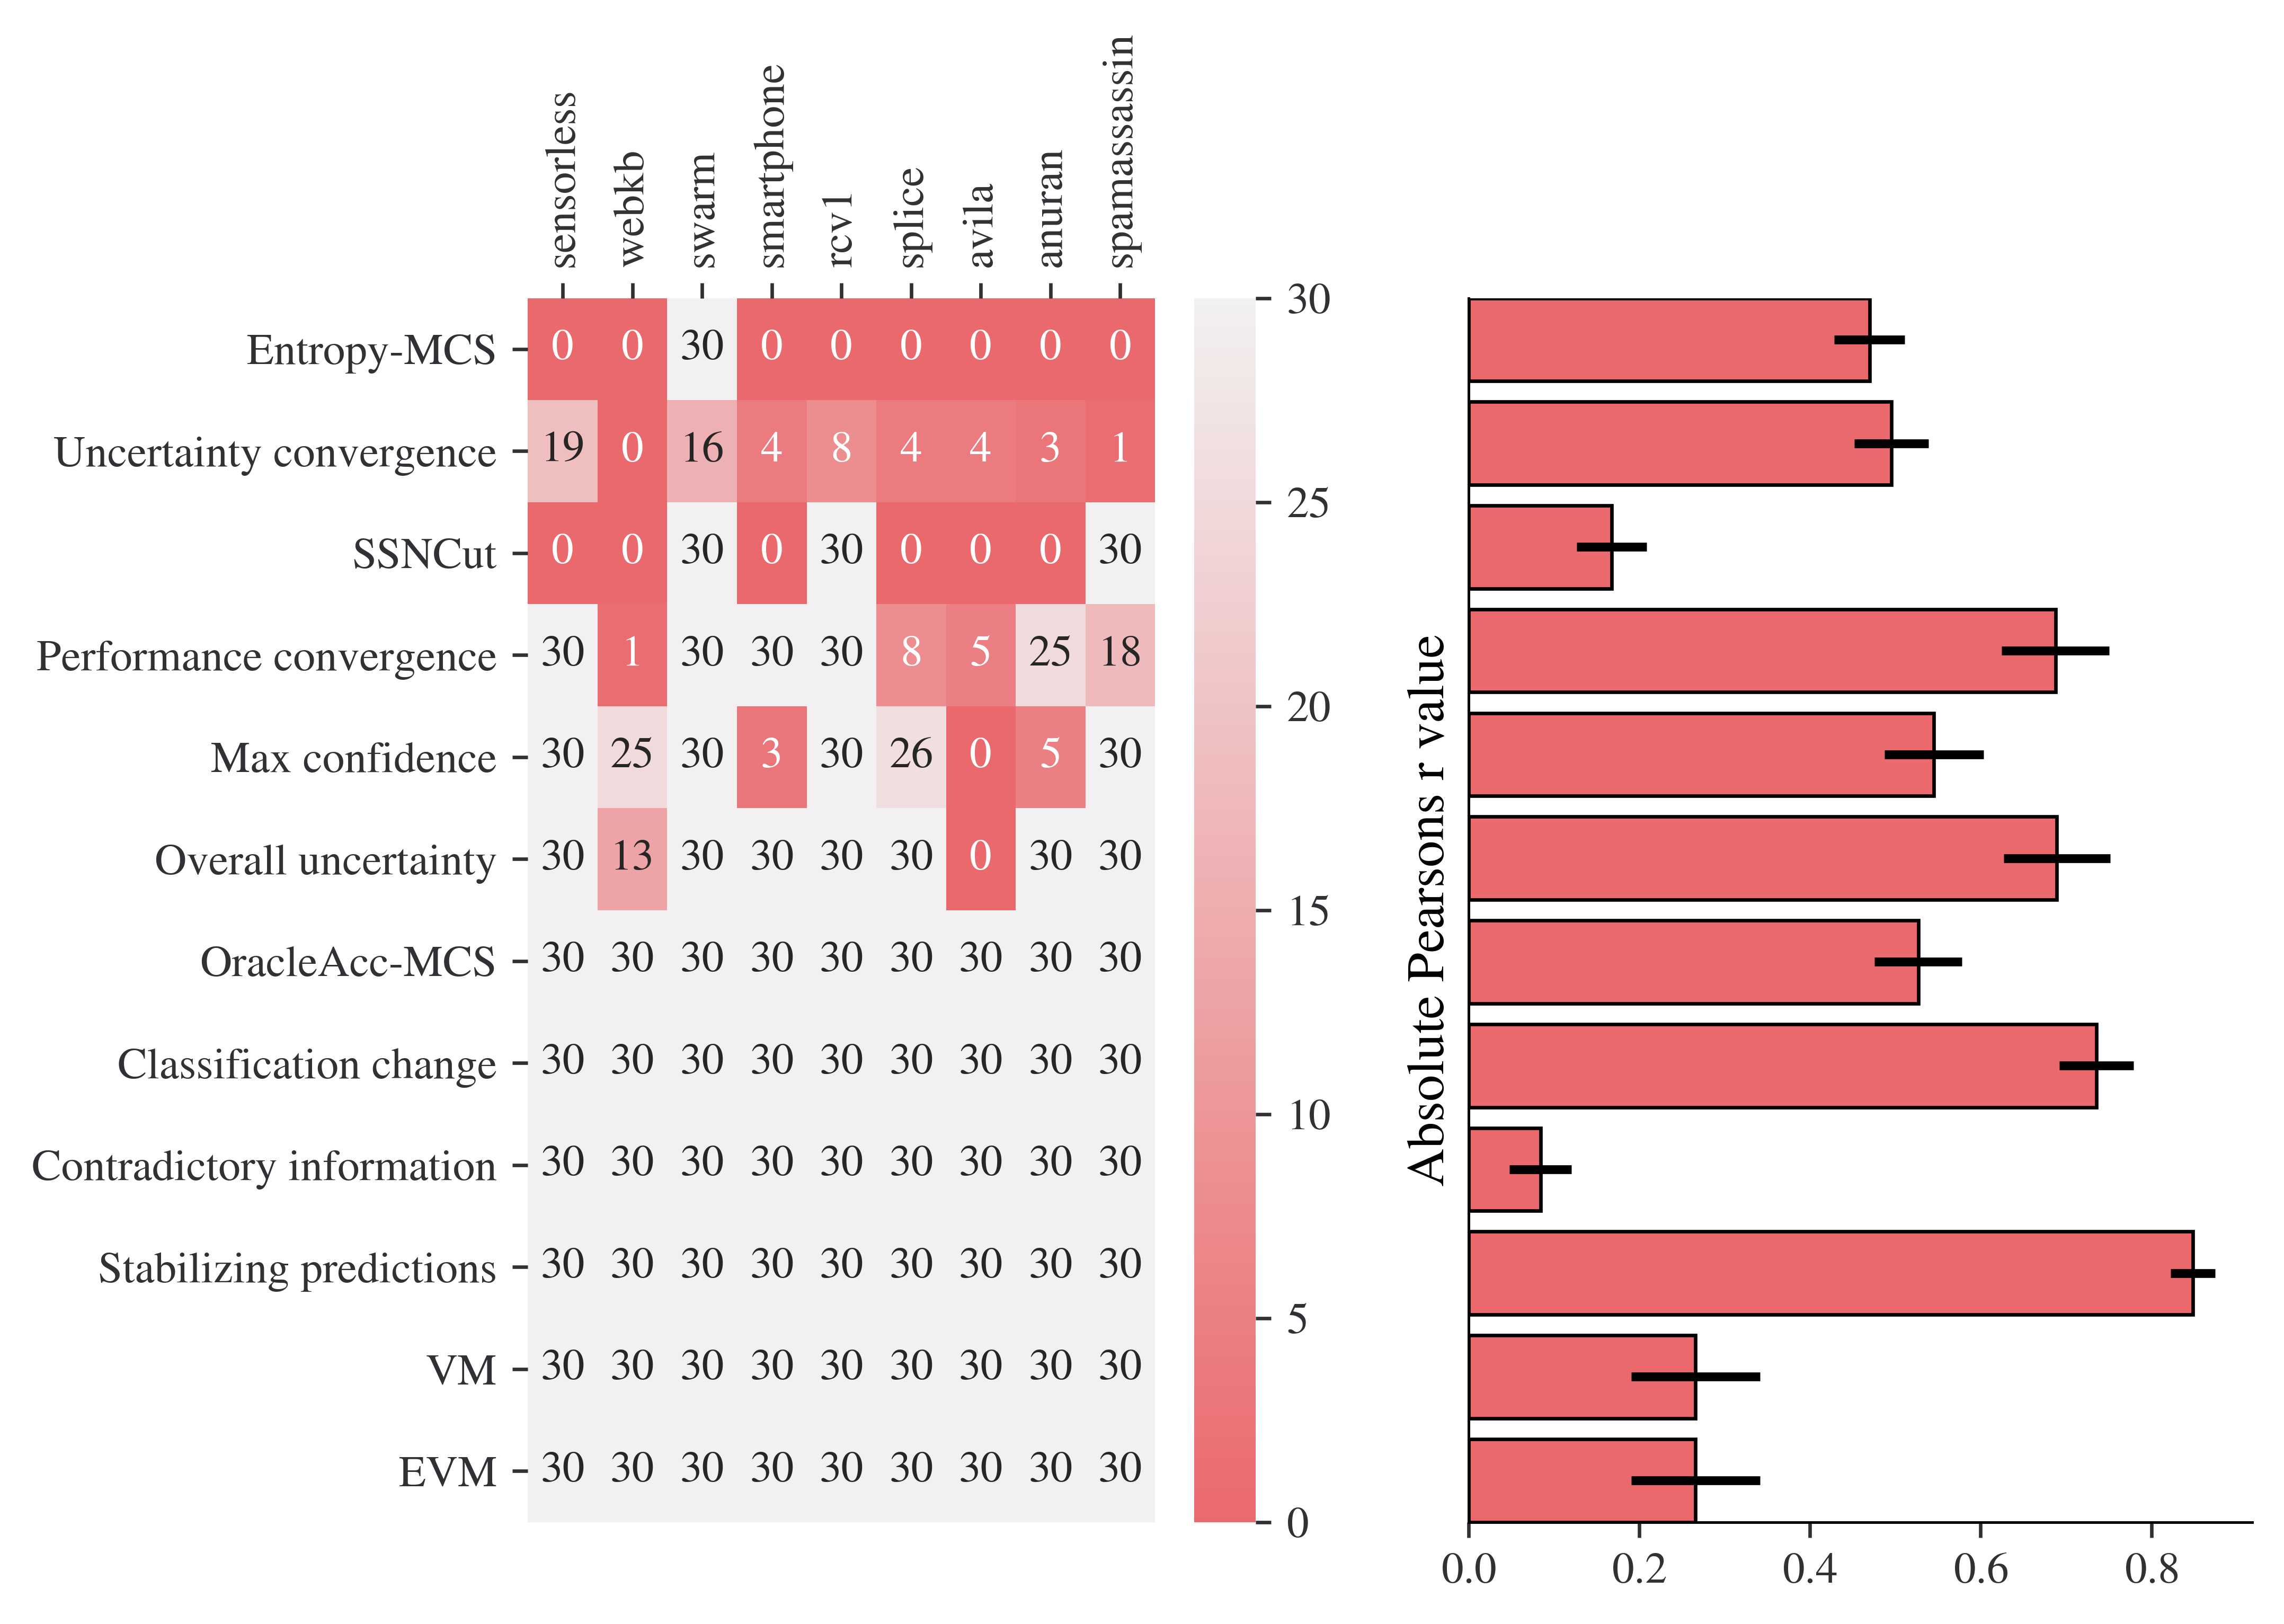

In [2227]:
with plt.style.context('plt_style.txt'):
    fig, axes = plt.subplots(1,2, figsize=(7,5), dpi=600)
    order = failed_to_stop.sum().sort_values().index
    cframe = correlations_frame.iloc[correlations_frame.index.get_indexer(order[::-1])]
    failed_to_stop_plot(axes[0], failed_to_stop[order], color=cmap(11), alpha=0.6)
    plot_correlations(
        axes[1], 
        cframe.index, 
        cframe.r, 
        cframe.r_err, 
        labels=False,
        order=False,
        color=cmap(11),
        alpha=0.6
    )
    
print(axes[0].get_ylim())
print(axes[1].get_ylim())
axes[1].set_ylim((-.4, 11.4))
plt.savefig('pdf/combined_svm.pdf', bbox_inches='tight')

### Correlations table

In [2270]:
print(cframe.to_dict())

{'r': {'EVM': -0.26600341526504134, 'VM': -0.26600341526504134, 'Stabilizing predictions': 0.84860463314479, 'Contradictory information': -0.08435733651318827, 'Classification change': 0.7356570041244502, 'OracleAcc-MCS': 0.5269248503621521, 'Overall uncertainty': -0.6893655050103312, 'Max confidence': -0.5453368712560761, 'Performance convergence': 0.6877434428386748, 'SSNCut': 0.16747970059684883, 'Uncertainty convergence': -0.49536188004697057, 'Entropy-MCS': -0.46970535736399277}, 'r_err': {'EVM': 0.07532600720260149, 'VM': 0.07532600720260149, 'Stabilizing predictions': 0.02608357132202049, 'Contradictory information': 0.036385776944744874, 'Classification change': 0.04324764699556392, 'OracleAcc-MCS': 0.05135268839491458, 'Overall uncertainty': 0.06222657044014579, 'Max confidence': 0.05790039199795675, 'Performance convergence': 0.06292719400001315, 'SSNCut': 0.04091202466561481, 'Uncertainty convergence': 0.04340229637309098, 'Entropy-MCS': 0.0413162536480056}}


In [2243]:
for _, row in cframe.iterrows():
    print(f"{row.name.ljust(30)} ${np.abs(row.r):.2f}\pm{row.r_err:.2f}$")

EVM                            $0.27\pm0.08$
VM                             $0.27\pm0.08$
Stabilizing predictions        $0.85\pm0.03$
Contradictory information      $0.08\pm0.04$
Classification change          $0.74\pm0.04$
OracleAcc-MCS                  $0.53\pm0.05$
Overall uncertainty            $0.69\pm0.06$
Max confidence                 $0.55\pm0.06$
Performance convergence        $0.69\pm0.06$
SSNCut                         $0.17\pm0.04$
Uncertainty convergence        $0.50\pm0.04$
Entropy-MCS                    $0.47\pm0.04$


## Raw Results

In [93]:
table = []
for dataset, methods in results_filter.items():
    for method, results in methods.items():
        r = np.array(results)
        r = r[r[:,0]!=None]
        if len(r) == 0:
            table.append([dataset, method, *[None]*3])
            continue
        
        mean = np.mean(r, axis=0)
        # 2.5% percentile to 97.5%
        lower = np.percentile(r, 2.5, axis=0)
        upper = np.percentile(r, 97.5, axis=0)
        
        data = []
        for i in range(4):
            #data.append(f"{upper[i]:.2f}|{mean[i]:.2f}|{lower[i]:.2f}")
            data.append(upper[i])
            data.append(mean[i])
            data.append(lower[i])
    
        table.append(
            [dataset, method, *data]
        )

In [94]:
tabulate(
    table,
    tablefmt='html',
    headers=['Dataset', 'Method', 'Instances (Upper)', "Instances (Mean)", 'Instances (Lower)', 'Accuracy (Upper)', 'Accuracy (Mean)', 'Accuracy (Lower)', 'F1 (Upper)', 'F1 (Mean)', 'F1 (Lower)', 'ROC (Upper)', 'ROC (Mean)', 'ROC (Lower)'],
    floatfmt=('', '', *['g']*3, *['.2%']*6)
)

Dataset,Method,Instances (Upper),Instances (Mean),Instances (Lower),Accuracy (Upper),Accuracy (Mean),Accuracy (Lower),F1 (Upper),F1 (Mean),F1 (Lower),ROC (Upper),ROC (Mean),ROC (Lower)
webkb,GOAL,434.25,278,131.25,87.83%,74.46%,57.02%,87.83%,74.46%,57.02%,0.965526,0.913381,0.828042
webkb,SSNCut,,,,,,,,,,,,
webkb,SC_entropy_mcs,,,,,,,,,,,,
webkb,SC_oracle_acc,646,296,44.5,89.11%,71.23%,36.26%,89.11%,71.23%,36.26%,0.97251,0.886621,0.736938
webkb,Stabilizing Predictions,745.25,615,544.5,90.87%,89.00%,87.48%,90.87%,89.00%,87.48%,0.973699,0.965195,0.941108
webkb,Performance Convergence,,,,,,,,,,,,
webkb,Uncertainty Convergence,,,,,,,,,,,,
webkb,Max Confidence,1540,750,10,89.70%,66.25%,30.05%,89.70%,66.25%,30.05%,0.977654,0.717228,0.28901
webkb,EVM,616.5,200,50,88.78%,58.46%,34.19%,88.78%,58.46%,34.19%,0.956576,0.841857,0.750883
webkb,VM,70,56,50,58.47%,44.35%,32.46%,58.47%,44.35%,32.46%,0.844025,0.778234,0.71372


In [2248]:
np.arange(30)[-10:]

array([20, 21, 22, 23, 24, 25, 26, 27, 28, 29])